In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
import urllib.request

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
def get_data(file_path, dir_path, remote_path):
    if file_path.exists():
        print(f"The path '{file_path}' exists.")
    else:
        dir_path.mkdir(parents=True, exist_ok=True)
        print(f"Downloading data from {remote_path}...")
        urllib.request.urlretrieve(remote_path, file_path)
    return pd.read_csv(file_path)

directory_path = Path('data')
file_path = directory_path / 'car_fuel_efficiency.csv'
data_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

df =  get_data(file_path, directory_path, data_url)
df.head()


The path 'data/car_fuel_efficiency.csv' exists.


,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
df.engine_displacement = df.engine_displacement.fillna(0)
df.num_cylinders = df.num_cylinders.fillna(0)
df.horsepower = df.horsepower.fillna(0)
df.num_doors = df.num_doors.fillna(0)
df.acceleration = df.acceleration.fillna(0)
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [7]:
df_full_train, df_test = train_test_split(df, test_size = 0.2,  random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25,  random_state = 1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)


In [9]:
y_train =  df_train['fuel_efficiency_mpg']
y_test =  df_test['fuel_efficiency_mpg']
y_val =  df_val['fuel_efficiency_mpg']


df_train = df_train.drop('fuel_efficiency_mpg', axis=1)
df_test = df_test.drop('fuel_efficiency_mpg', axis=1)
df_val = df_val.drop('fuel_efficiency_mpg', axis=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [21]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

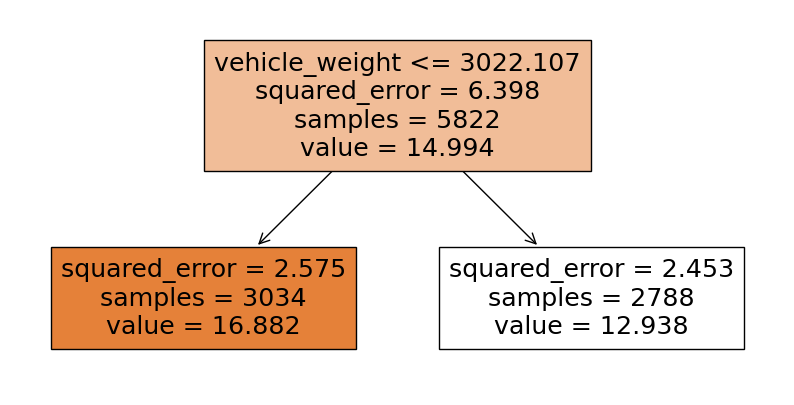

In [23]:
dt = DecisionTreeRegressor(max_depth=1)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

plt.figure(figsize=(10, 5))
feature_names = dv.get_feature_names_out()
tree.plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

In [25]:
rf = RandomForestRegressor(
    n_estimators=10,      # number of trees
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False returns RMSE
print("RMSE:", rmse)

RMSE: 0.44943701045630724


In [45]:
# Define the hyperparameter ranges
max_depth_values = [10, 15, 20, 25]
n_estimators_values = range(10, 201, 10)

# Dictionary to store RMSE results
rmse_results = []

# Loop over max_depth and n_estimators
for max_depth in max_depth_values:
    rmse_results = []
    for n in n_estimators_values:
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_results.append(rmse)

    # Calculate average RMSE for each n_estimators
    average_rmse = round(sum(rmse_results)/len(rmse_results), 3) 

    print(f"max_depth={max_depth}, Average RMSE={average_rmse}")

max_depth=10, Average RMSE=0.432
max_depth=15, Average RMSE=0.434
max_depth=20, Average RMSE=0.434
max_depth=25, Average RMSE=0.434


In [49]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importances as a NumPy array
feature_importances_ndarray = rf.feature_importances_

# Optionally, print them
for feature_name, importance in zip(feature_names, feature_importances_ndarray):
    print(f"{feature_name}: {importance:.4f}")

acceleration: 0.0115
drivetrain=All-wheel drive: 0.0004
drivetrain=Front-wheel drive: 0.0003
engine_displacement: 0.0033
fuel_type=Diesel: 0.0004
fuel_type=Gasoline: 0.0003
horsepower: 0.0160
model_year: 0.0032
num_cylinders: 0.0023
num_doors: 0.0016
origin=Asia: 0.0005
origin=Europe: 0.0005
origin=USA: 0.0006
vehicle_weight: 0.9592


In [68]:
# 1. Install XGBoost (if not installed)
# %pip install --upgrade pip
# %pip install xgboost --index-url https://pypi.org/simple


import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 2. Prepare your data
# Assuming you have X_train, y_train, X_val, y_val already

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# 3. Watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

# 4. Train function
def train_xgb(eta_value):
    params = {
        'eta': eta_value,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        evals=watchlist,
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    y_pred = model.predict(dval)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

# 5. Compare two eta values
rmse_03 = train_xgb(0.3)
rmse_01 = train_xgb(0.1)

print("RMSE with eta=0.3:", rmse_03)
print("RMSE with eta=0.1:", rmse_01)

if rmse_03 < rmse_01:
    print("Best eta: 0.3")
elif rmse_01 < rmse_03:
    print("Best eta: 0.1")
else:
    print("Both give equal value")


RMSE with eta=0.3: 0.43592081487338186
RMSE with eta=0.1: 0.4251954985808973
Best eta: 0.1
